In [1]:
import os
import json
from collections import defaultdict
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import softmax
from scipy.stats import entropy

from fairseq import tasks, options

In [167]:
MODEL_PATH

'mtransformer/de-en/model1.pt:mtransformer/de-en/model2.pt:mtransformer/de-en/model3.pt:mtransformer/de-en/model4.pt:mtransformer/de-en/model5.pt'

In [2]:
MODEL_PATH = 'mtransformer/de-en/'
CHECKPOINT_PATHS = [
    'model1.pt',
    'model2.pt',
    'model3.pt',
    'model4.pt',
    'model5.pt',
]
CHECKPOINT_PATHS = [os.path.join(MODEL_PATH, path) for path in CHECKPOINT_PATHS]

MODEL_PATH = ':'.join(CHECKPOINT_PATHS)
BINARY_DATA_PATH = 'data-bin/iwslt14.tokenized.de-en/'
# BPECODES_PATH = 'wmt19.en-ru.ensemble/codes'
BPECODES_PATH = 'data/iwslt14.tokenized.de-en/code' # иначе лажа какая-то получается
BEAM = '5'
LENPEN = '0.6'
DIVERSE_BEAM_STRENGTH = '0'
SHARED_BPE = True
SRS = "en"
TGT = "ru"

parser = options.get_generation_parser(interactive=True)

args = options.parse_args_and_arch(parser, input_args=[
    BINARY_DATA_PATH,
    '--path', MODEL_PATH,
    '--diverse-beam-strength', DIVERSE_BEAM_STRENGTH,
    '--lenpen', 0,
    '--remove-bpe',
    '--beam', BEAM
])

use_cuda = False
task = tasks.setup_task(args)
tgt_dict = task.target_dictionary

| [de] dictionary: 8848 types
| [en] dictionary: 6632 types


In [3]:
MODELS_NUM = 5

---

#### Моделирование softmax

In [4]:
def plot_softmax(tokens, probs, title, label, ax, f_ylim=True): 
    ax.plot(tokens, probs, alpha=.5, label=label)
    ax.scatter(tokens, probs, alpha=.5)
    if f_ylim:
        ax.set_ylim(0, 1)
    ax.set_xlabel('token')
    ax.set_ylabel('token prob $p(y)$')
    ax.set_title(title + ' softmax')
    ax.grid()
    ax.legend()

In [ ]:
NSAMPLES = 10
probs_grid = []
tokens = np.arange(5)
for i in range(NSAMPLES):
    probs = np.random.uniform(0, 1, 5)
    probs_grid.append(probs)

In [ ]:
m = 3
n = len(probs_grid) // m + (1 if len(probs_grid) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, probs in enumerate(probs_grid):
    # assert np.sum(probs) == 1
    probs = np.array(probs)
    variance = np.var(np.log(probs + 1e-10))
    
    ax = plt.subplot(n, m, i + 1)
    plot_softmax(tokens, probs, '', r'$\sigma^2={:.4f}$'.format(variance), ax)

In [ ]:
M = 15
N = len(tgt_dict.symbols)
tokens = np.arange(N)

probs_grid = []
for i in range(M):
    probs = []
    cumsum = 0
    for i in range(N):
        value = np.random.uniform(0, 1 - cumsum)
        cumsum += value
        probs.append(value)
        
    probs_grid.append(np.array(probs))

In [ ]:
m = 3
n = len(probs_grid) // m + (1 if len(probs_grid) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, probs in enumerate(probs_grid):
    value = entropy(probs)
    
    ax = plt.subplot(n, m, i + 1)
    np.random.shuffle(probs)
    plot_softmax(tokens, probs, '', r'$\mathcal{{H}}(softmax)={:.4f}$'.format(value), ax)

In [ ]:
M = 15
N = len(tgt_dict.symbols)
tokens = np.arange(N)

probs_grid = []
for i in range(M):
    variance = np.random.uniform(0, 10)
    probs = softmax(np.random.normal(0, variance, size=N))
    probs_grid.append(np.array(probs))

In [ ]:
m = 3
n = len(probs_grid) // m + (1 if len(probs_grid) % m != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, probs in enumerate(probs_grid):
    value = entropy(probs)
    
    ax = plt.subplot(n, m, i + 1)
    np.random.shuffle(probs)
    plot_softmax(tokens, probs, '', r'$\mathcal{{H}}(softmax)={:.4f}$'.format(value), ax, False)

In [ ]:
plt.figure(figsize=(8, 6))

N = len(tgt_dict.symbols)
tokens = np.arange(N)
probs = np.array([1 / N]* (N)) + 1e-10
value = entropy(probs)
    
ax = plt.subplot(1, 1, 1)
np.random.shuffle(probs)
plot_softmax(tokens, probs, 'singular', r'$\mathcal{{H}}(softmax)={:.8f}$'.format(value), ax, False)

---

In [5]:
def plot_stats(
    beams,
    beam2stats_pos,
    beam2stats_neg,
    beam2stats_wrong,
    stat,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    eos_token=None,
    map_func=lambda x: x
):
    density = stacked = normalized
    if not normalized:
        xlim, ylim = None, None
        
    m = 2
    n = len(beams)

    pos_name, beam2stats_pos = beam2stats_pos
    neg_name, beam2stats_neg = beam2stats_neg
    wrong_name, beam2stats_wrong = beam2stats_wrong
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, m * i + 1)
        ax.hist(
            map_func(beam2stats_pos[beam][stat]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='{} ({})'.format(pos_name, len(beam2stats_pos[beam][stat]))
        )
        if eos_token is not None:
            pos_stats = np.array(beam2stats_pos[beam][stat])
            mask = np.array(beam2stats_pos[beam]['tokens']) == eos_token
            ax.hist(
                map_func(pos_stats[mask]),
                density=density, stacked=stacked,
                color='darkred', alpha=.4,
                bins=70,
                label='{}(eos) ({})'.format(pos_name, pos_stats[mask].shape[0])
            )
            
        ax.hist(
            map_func(beam2stats_neg[beam][stat]),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='{} ({})'.format(neg_name, len(beam2stats_neg[beam][stat]))
        )
        if eos_token is not None:
            neg_stats = np.array(beam2stats_neg[beam][stat])
            mask = np.array(beam2stats_neg[beam]['tokens']) == eos_token
            ax.hist(
                map_func(neg_stats[mask]),
                density=density, stacked=stacked,
                color='darkblue', alpha=.4,
                bins=70,
                label='{} (eos) ({})'.format(neg_name, neg_stats[mask].shape[0])
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

        ax = plt.subplot(n, m, m * i + 2)
        wrong_stat = np.array(beam2stats_wrong[beam][stat])
        pos_mask = np.array(beam2stats_wrong[beam]['is_true'])
        if eos_token is not None:
            eos_mask = np.array(beam2stats_wrong[beam]['tokens'] == eos_token)
        ax.hist(
            map_func(wrong_stat[pos_mask]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='{} positive ({})'.format(wrong_name, wrong_stat[pos_mask].shape[0])
        )
        if eos_token is not None:
            ax.hist(
                map_func(wrong_stat[pos_mask & eos_mask]),
                density=density, stacked=stacked,
                color='darkred', alpha=.4,
                bins=70,
                label='{} positive(eos) ({})'.format(wrong_name, wrong_stat[pos_mask & eos_mask].shape[0])
            )
        ax.hist(
            map_func(wrong_stat[~pos_mask]),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='{} negative ({})'.format(wrong_name, wrong_stat[~pos_mask].shape[0])
        )
        if eos_token is not None:
            ax.hist(
                map_func(wrong_stat[(~pos_mask) & eos_mask]),
                density=density, stacked=stacked,
                color='darkblue', alpha=.4,
                bins=70,
                label='{} negative(eos) ({})'.format(wrong_name, wrong_stat[(~pos_mask) & eos_mask].shape[0])
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

In [6]:
def plot_stats_scatters(
    beams,
    beam2stats_first,
    beam2stats_second,
    stat_x,
    stat_y,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    eos_token=None,
    map_func_x=lambda x: x,
    map_func_y=lambda x: x
):
    density = stacked = normalized
    if not normalized:
        xlim, ylim = None, None
        
    m = 2
    n = len(beams)

    first_name, beam2stats_first = beam2stats_first
    second_name, beam2stats_second = beam2stats_second
    
    plt.figure(figsize=(8 * m, 6 * n))
    for i, beam in enumerate(sorted(beams)):
        ax = plt.subplot(n, m, m * i + 1)
        ax.scatter(
            map_func_x(beam2stats_first[beam][stat_x]),
            map_func_y(beam2stats_first[beam][stat_y]),
            color='red', alpha=.4,
            label='{}'.format(first_name)
        )
        if eos_token is not None:
            stats_x = np.array(beam2stats_first[beam][stat_x])
            stats_y = np.array(beam2stats_first[beam][stat_y])
            mask = np.array(beam2stats_first[beam]['tokens']) == eos_token
            ax.scatter(
                map_func_x(stats_x[mask]),
                map_func_y(stats_y[mask]),
                color='darkred', alpha=.4,
                label='{}(eos)'.format(first_name)
            )
            
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

        ax = plt.subplot(n, m, m * i + 2)
        ax.scatter(
            map_func_x(beam2stats_second[beam][stat_x]),
            map_func_y(beam2stats_second[beam][stat_y]),
            color='blue', alpha=.4,
            label='{}'.format(second_name)
        )
        if eos_token is not None:
            stats_x = np.array(beam2stats_second[beam][stat_x])
            stats_y = np.array(beam2stats_second[beam][stat_y])
            mask = np.array(beam2stats_second[beam]['tokens']) == eos_token
            ax.scatter(
                map_func_x(stats_x[mask]),
                map_func_y(stats_y[mask]),
                color='darkblue', alpha=.4,
                label='{}(eos)'.format(second_name)
            )
        ax.set_title('Beam Size: {}. {}'.format(beam, title))
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.grid()
        ax.legend()

stats_softmax

In [145]:
stats_dir = 'mtransformer/de-en/test/'

positive_filename = 'positive_stats.json'
negative_filename = 'negative_stats.json'
negative_true_filename = 'negative_true_stats.json'
wrong_filename = 'wrong_suff_stats.json'

In [146]:
beam2stats_pos = defaultdict(list)
beam2stats_neg = defaultdict(list)
beam2stats_neg_true = defaultdict(list)
beam2stats_wrong = defaultdict(list)

In [147]:
for beam_dir in os.listdir(stats_dir):
    beam = int(beam_dir.split('_')[-1])
    if beam != 2:
        continue
    
    path = os.path.join(stats_dir, beam_dir)
    with open(os.path.join(path, positive_filename)) as input_stream:
        beam2stats_pos[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_filename)) as input_stream:
        beam2stats_neg[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_true_filename)) as input_stream:
        beam2stats_neg_true[beam] = json.load(input_stream)
        
    with open(os.path.join(path, wrong_filename)) as input_stream:
        beam2stats_wrong[beam] = json.load(input_stream)

---

In [162]:
beam2stats_pos[2].keys()

dict_keys(['inens_probs_var', 'inens_probs_mean', 'inens_probs_dist', 'softmax_probs_var_models', 'softmax_probs_entropy_models', 'softmax_probs_var_ens', 'softmax_probs_entropy_ens', 'softmax_probs', 'prob', 'tokens'])

### token-level var. Wrong suffix -30

In [78]:
beam2stats_wrong[2].keys()

dict_keys(['prob', 'inens_var', 'inens_mean', 'ens_softmax', 'inens_dist', 'ens_svar', 'ens_entropy', 'm0_svar', 'm0_entropy', 'm1_svar', 'm1_entropy', 'm2_svar', 'm2_entropy', 'm3_svar', 'm3_entropy', 'm4_svar', 'm4_entropy', 'tokens', 'is_true'])

In [80]:
arr = np.array(beam2stats_wrong[2]['inens_var'])
tokens = np.array(beam2stats_wrong[2]['tokens'])

mask = (np.log2(arr) > -40) & (np.log2(arr) < -25)
# mask &= (tokens == 2)

softmaxes = np.array(beam2stats_wrong[2]['inens_dist'])[mask]

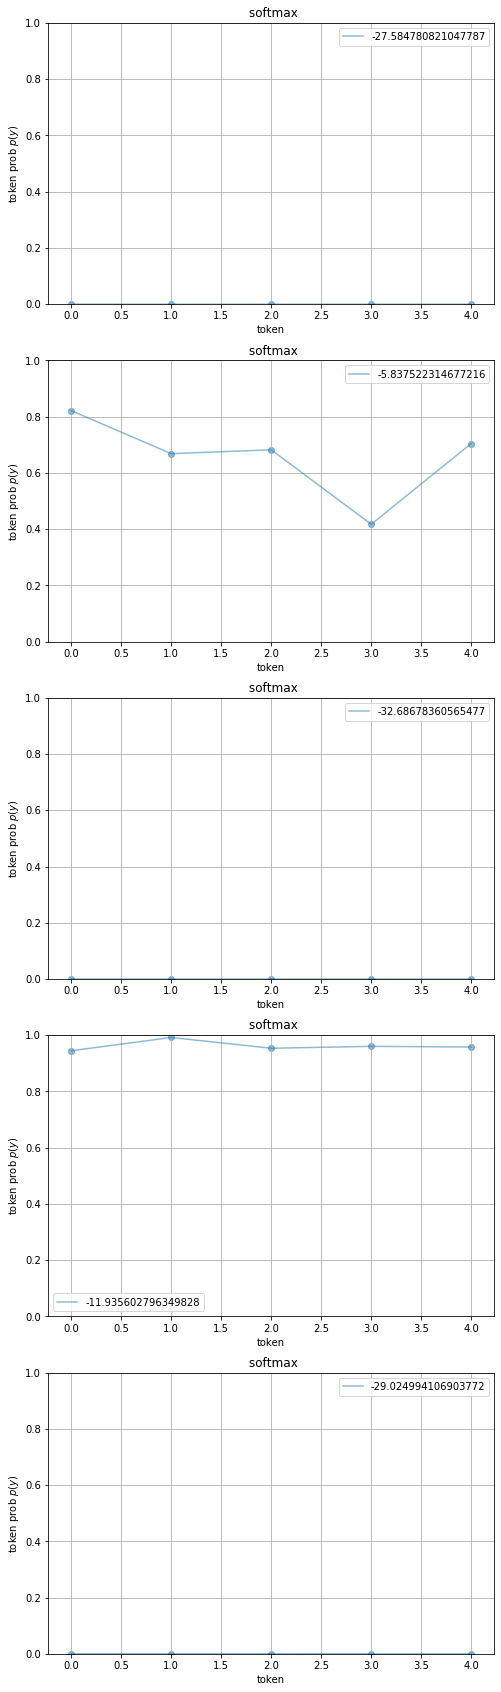

In [81]:
idxs = np.arange(len(softmaxes))
np.random.shuffle(idxs)

N = 5
plt.figure(figsize=(8, 6 * N))
for i, softmax in enumerate(softmaxes[idxs[:N]]):
    ax = plt.subplot(N, 1, i + 1)
    tokens = np.arange(len(softmax))
    plot_softmax(tokens, softmax, '', str(np.log2(softmax.var())), ax, f_ylim=True)

#### Log probs

In [68]:
beams = list(beam2stats_pos.keys())

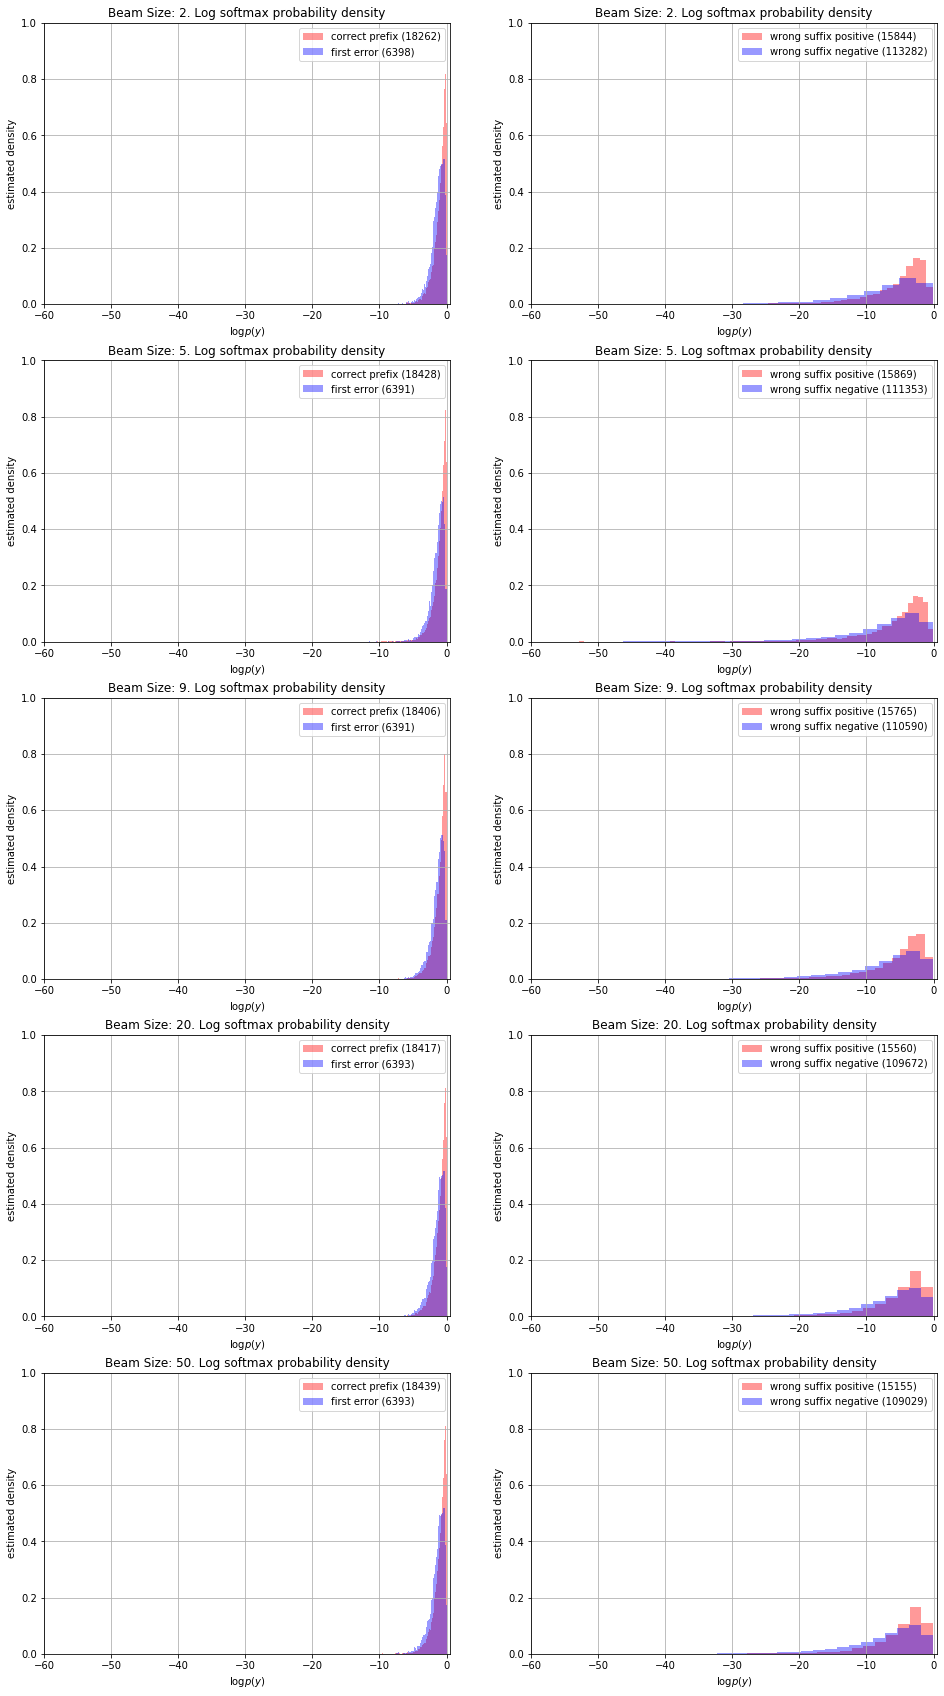

In [69]:
YLIM = (0, 1)
XLIM = (-60, 0.5)

NORMALIZED = True


TITLE = 'Log softmax probability density'
XLABEL = r'$\log p(y)$'
YLABEL = 'estimated density'

STAT = 'prob'
# EOS_TOKEN = tgt_dict.eos()
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN
)

---

#### Token-level variance

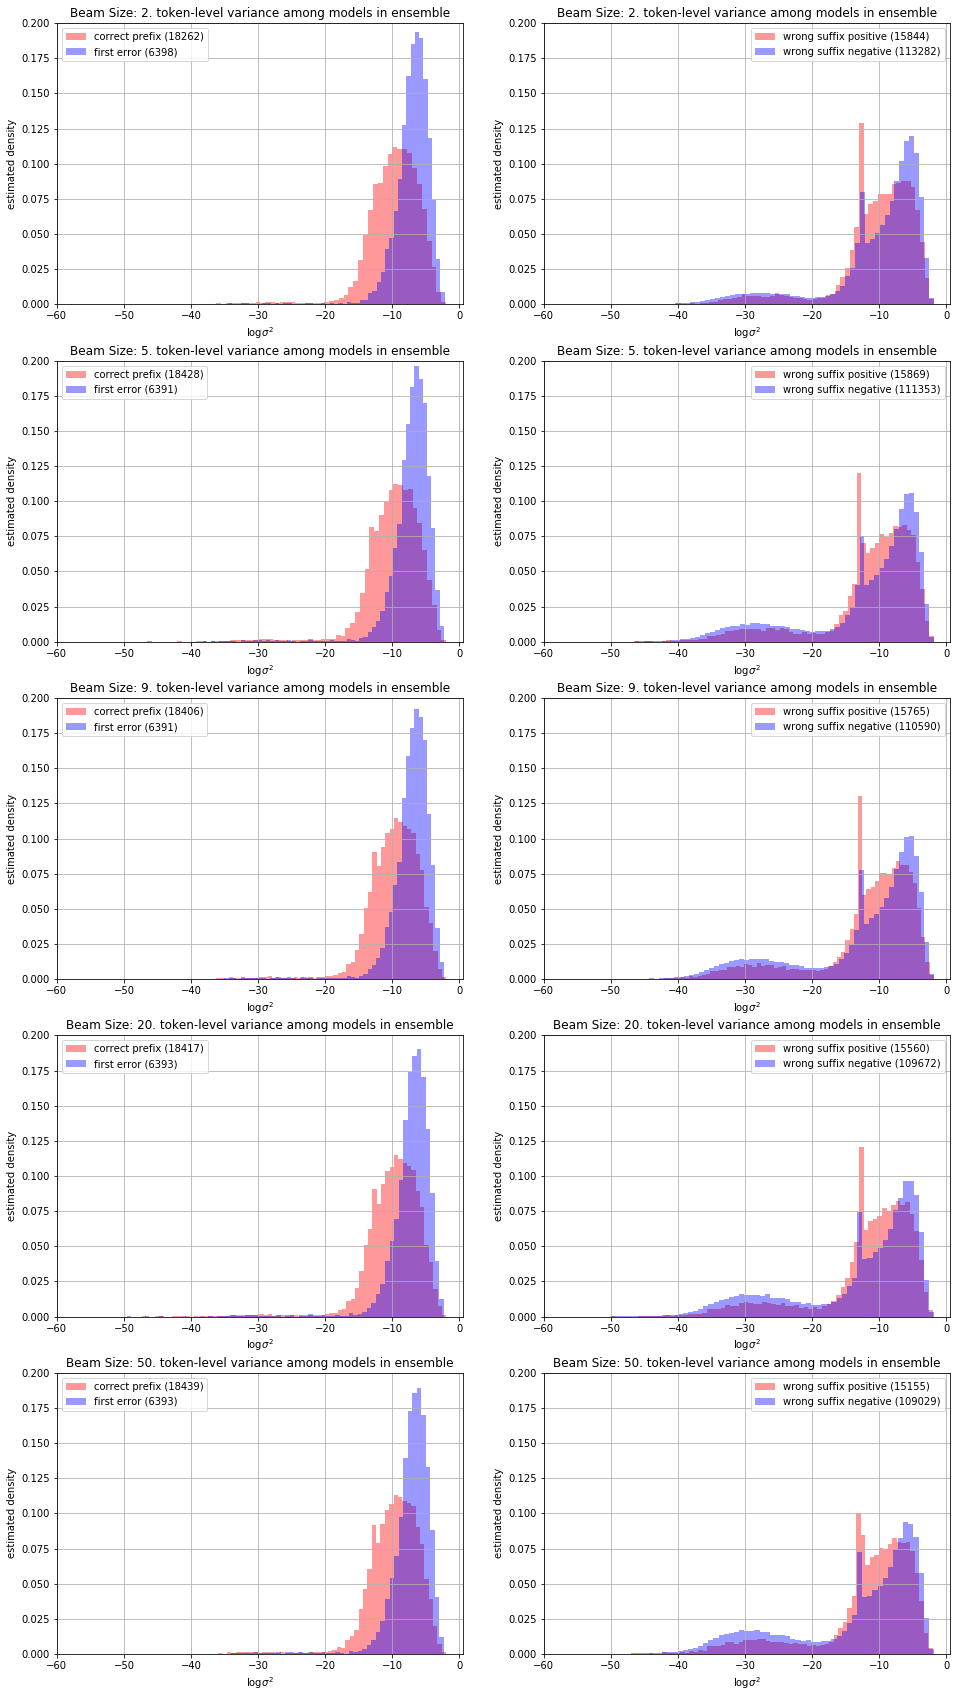

In [70]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models in ensemble'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT = 'inens_var'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.log2
)

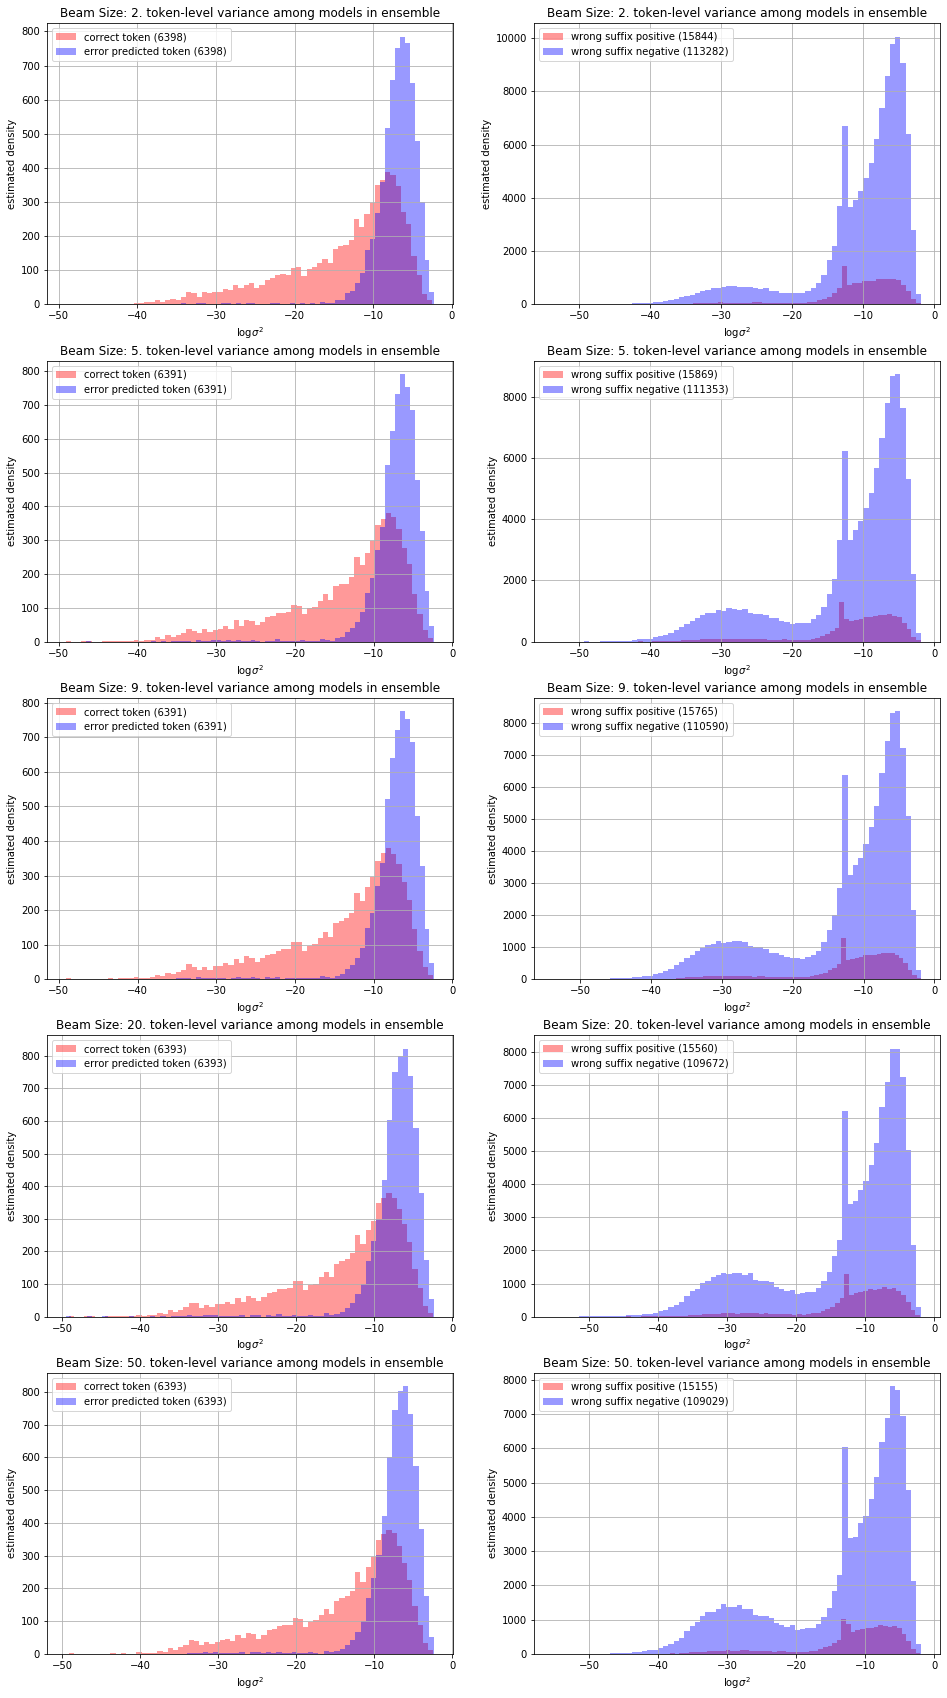

In [71]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models in ensemble'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT = 'inens_var'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct token', beam2stats_neg_true),
    ('error predicted token', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.log2
)

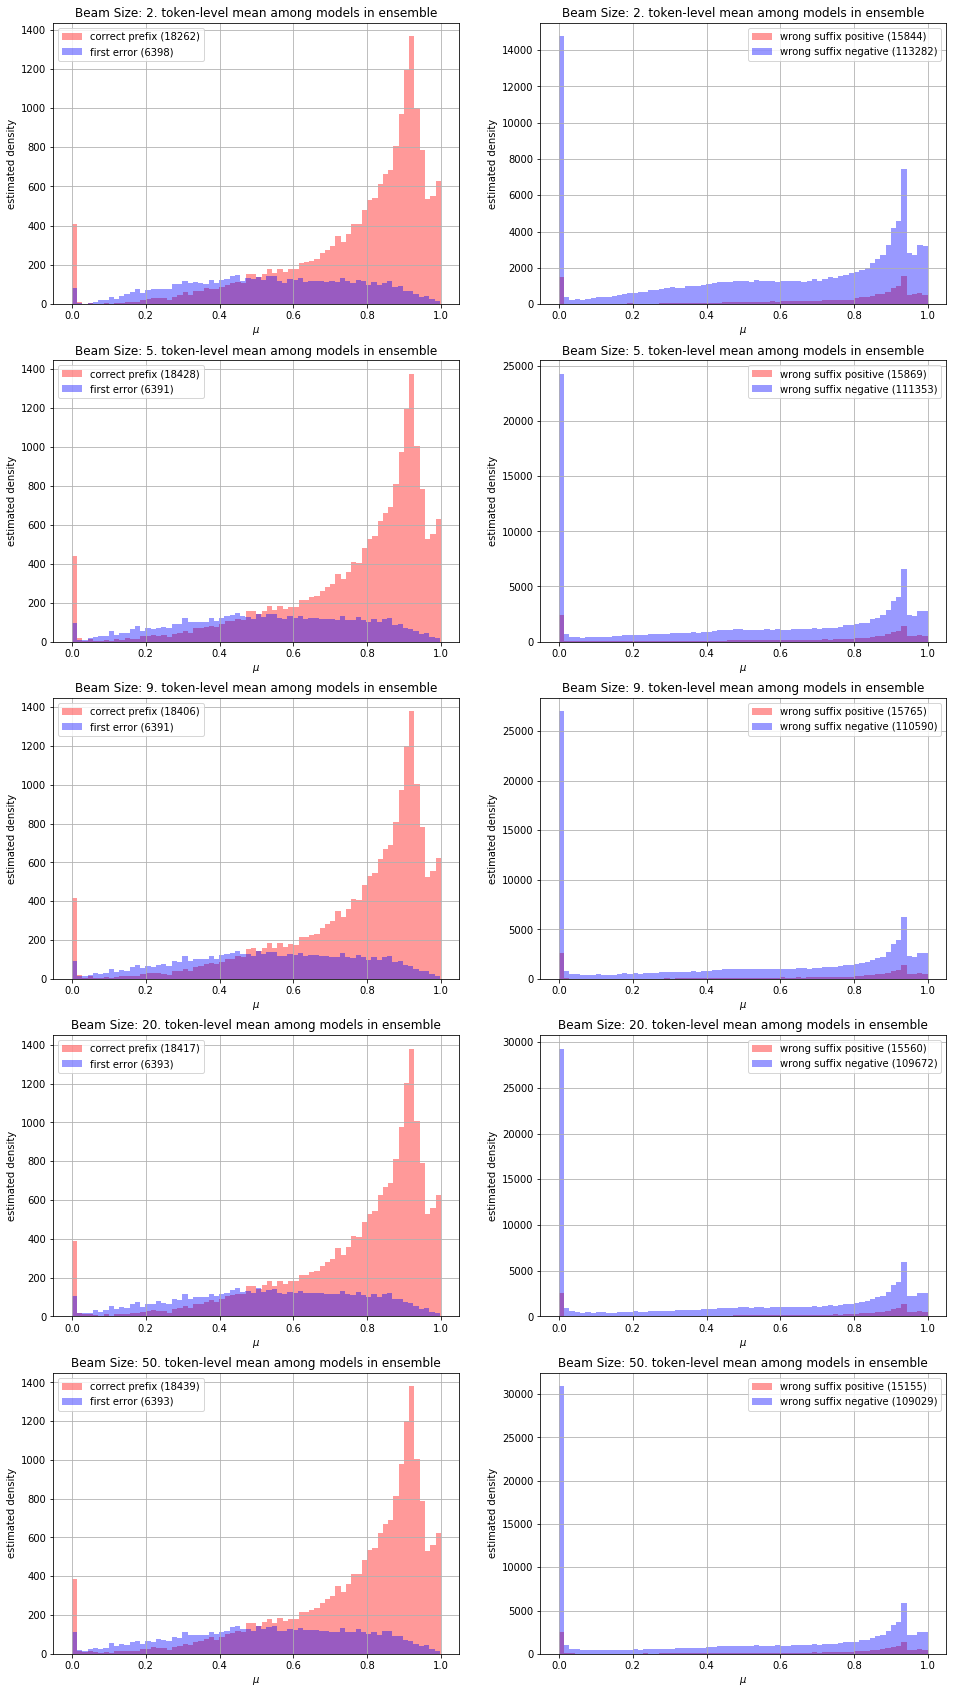

In [76]:
YLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLIM, YLIM = None, None

TITLE = 'token-level mean among models in ensemble'
XLABEL = r'$\mu$'
YLABEL = 'estimated density'

STAT = 'inens_mean'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN
)

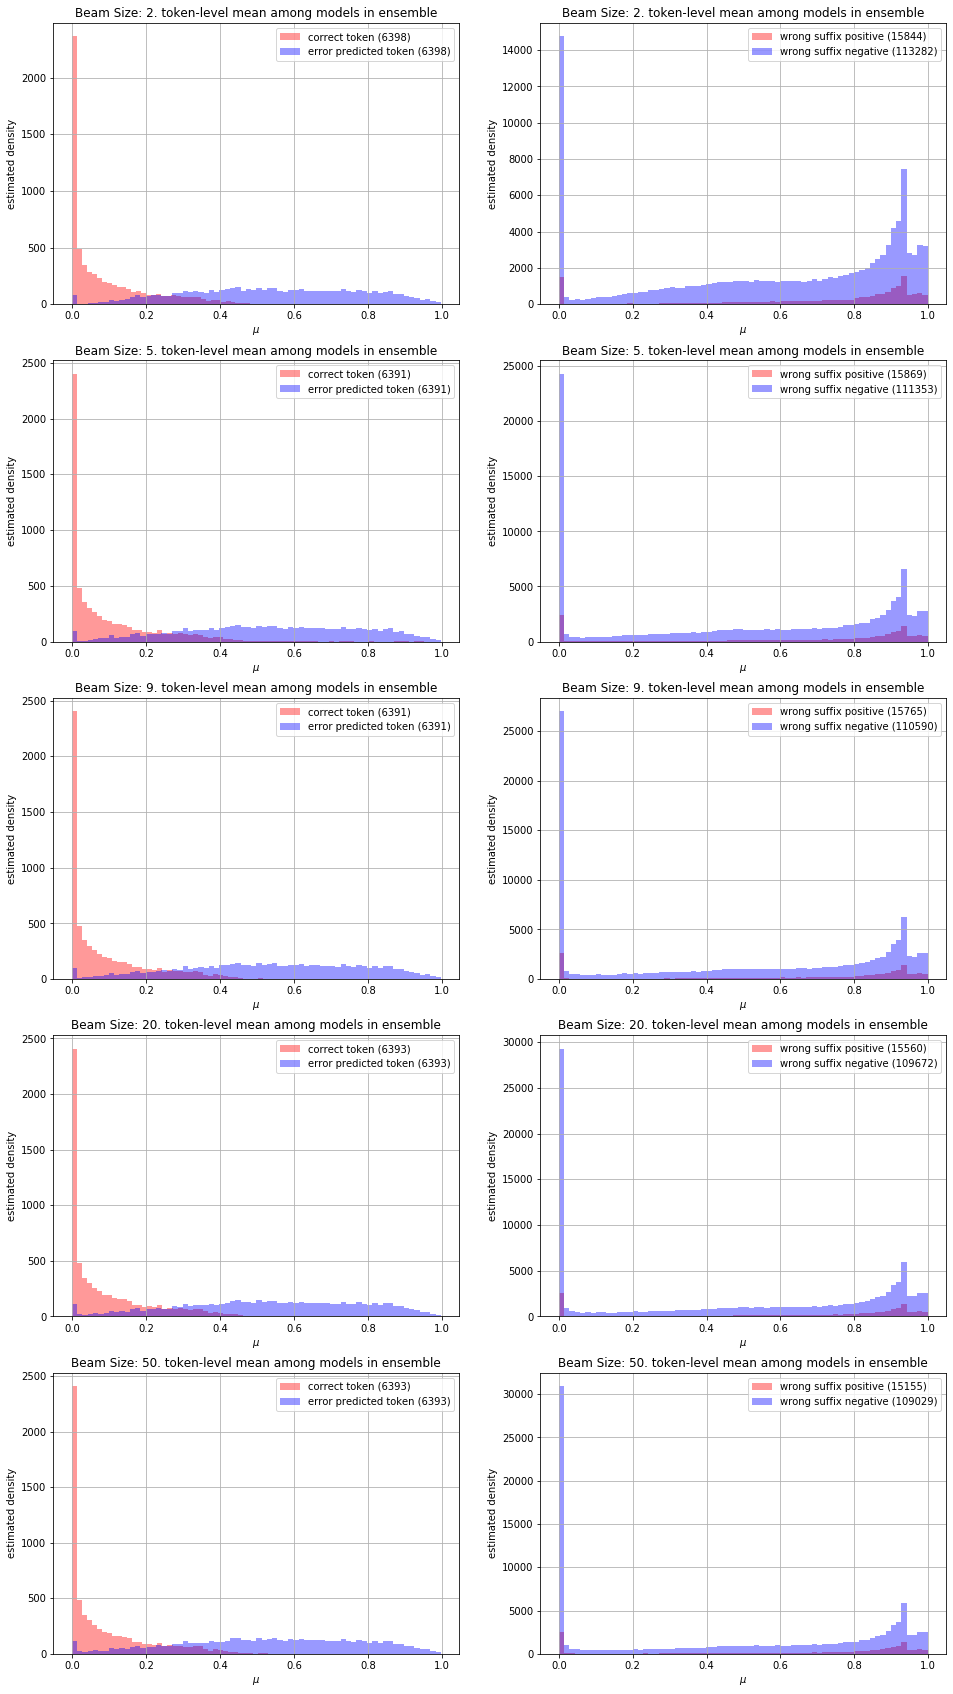

In [77]:
YLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLIM, YLIM = None, None

TITLE = 'token-level mean among models in ensemble'
XLABEL = r'$\mu$'
YLABEL = 'estimated density'

STAT = 'inens_mean'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct token', beam2stats_neg_true),
    ('error predicted token', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN
)

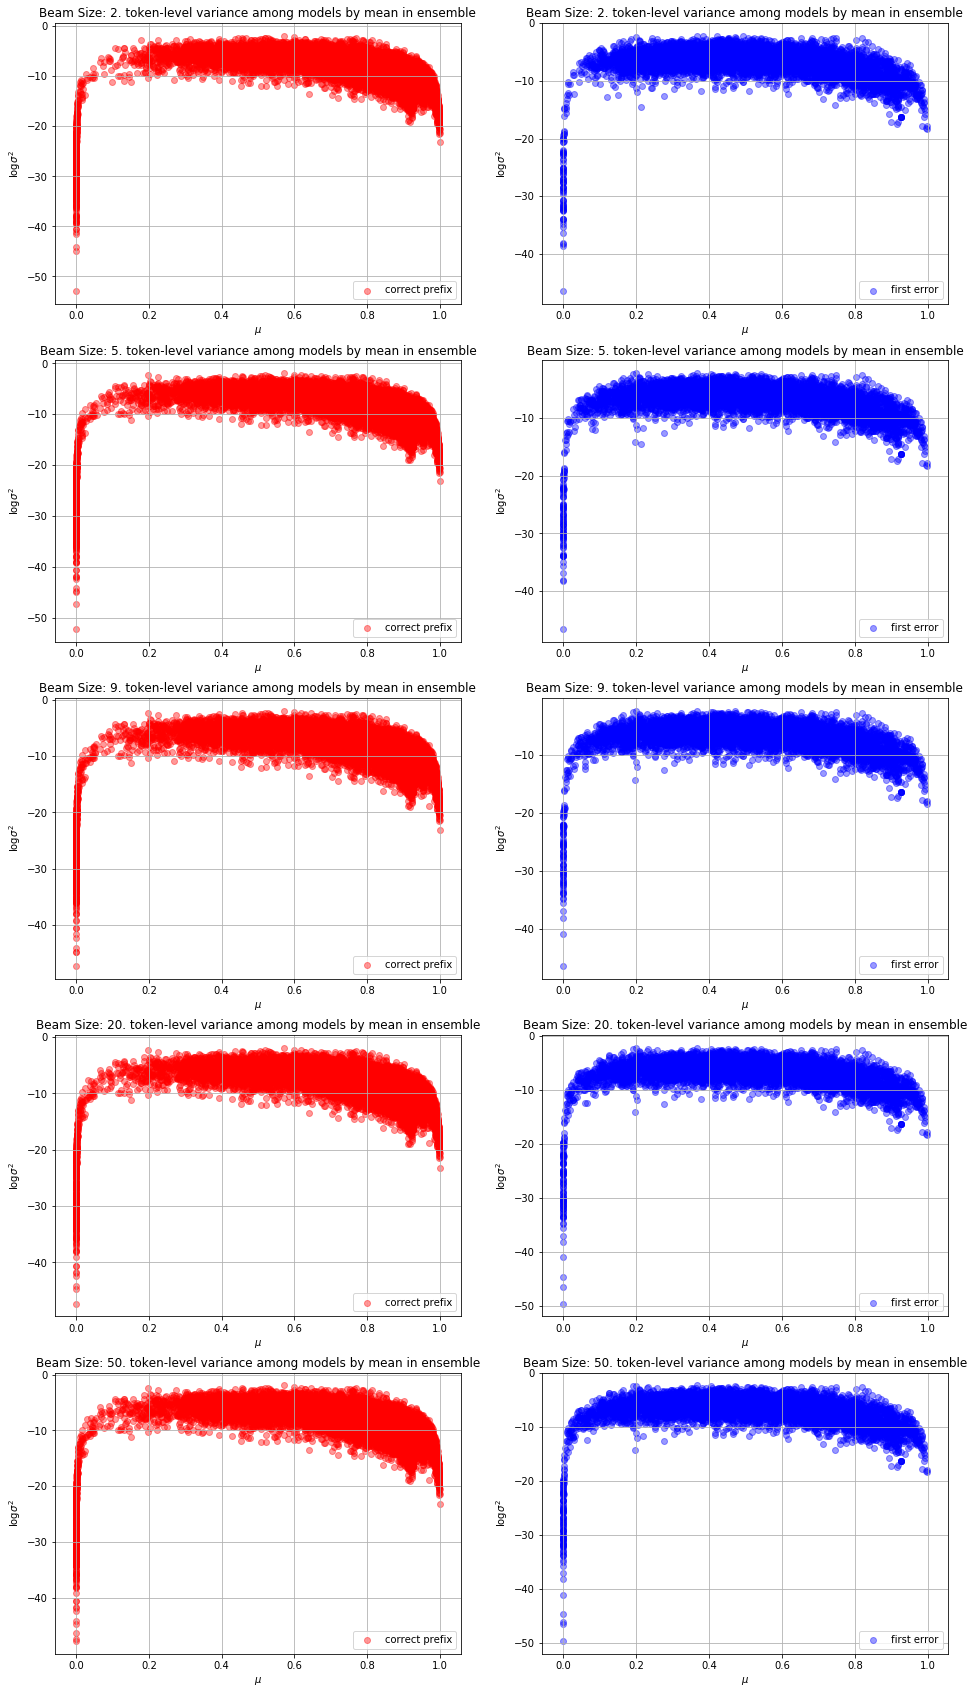

In [88]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models by mean in ensemble'
YLABEL = r'$\log \sigma^2$'
XLABEL = r'$\mu$'

STATX = 'inens_mean'
STATY = 'inens_var'
EOS_TOKEN = None

plot_stats_scatters(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    STATX,
    STATY,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    map_func_y=np.log2
)

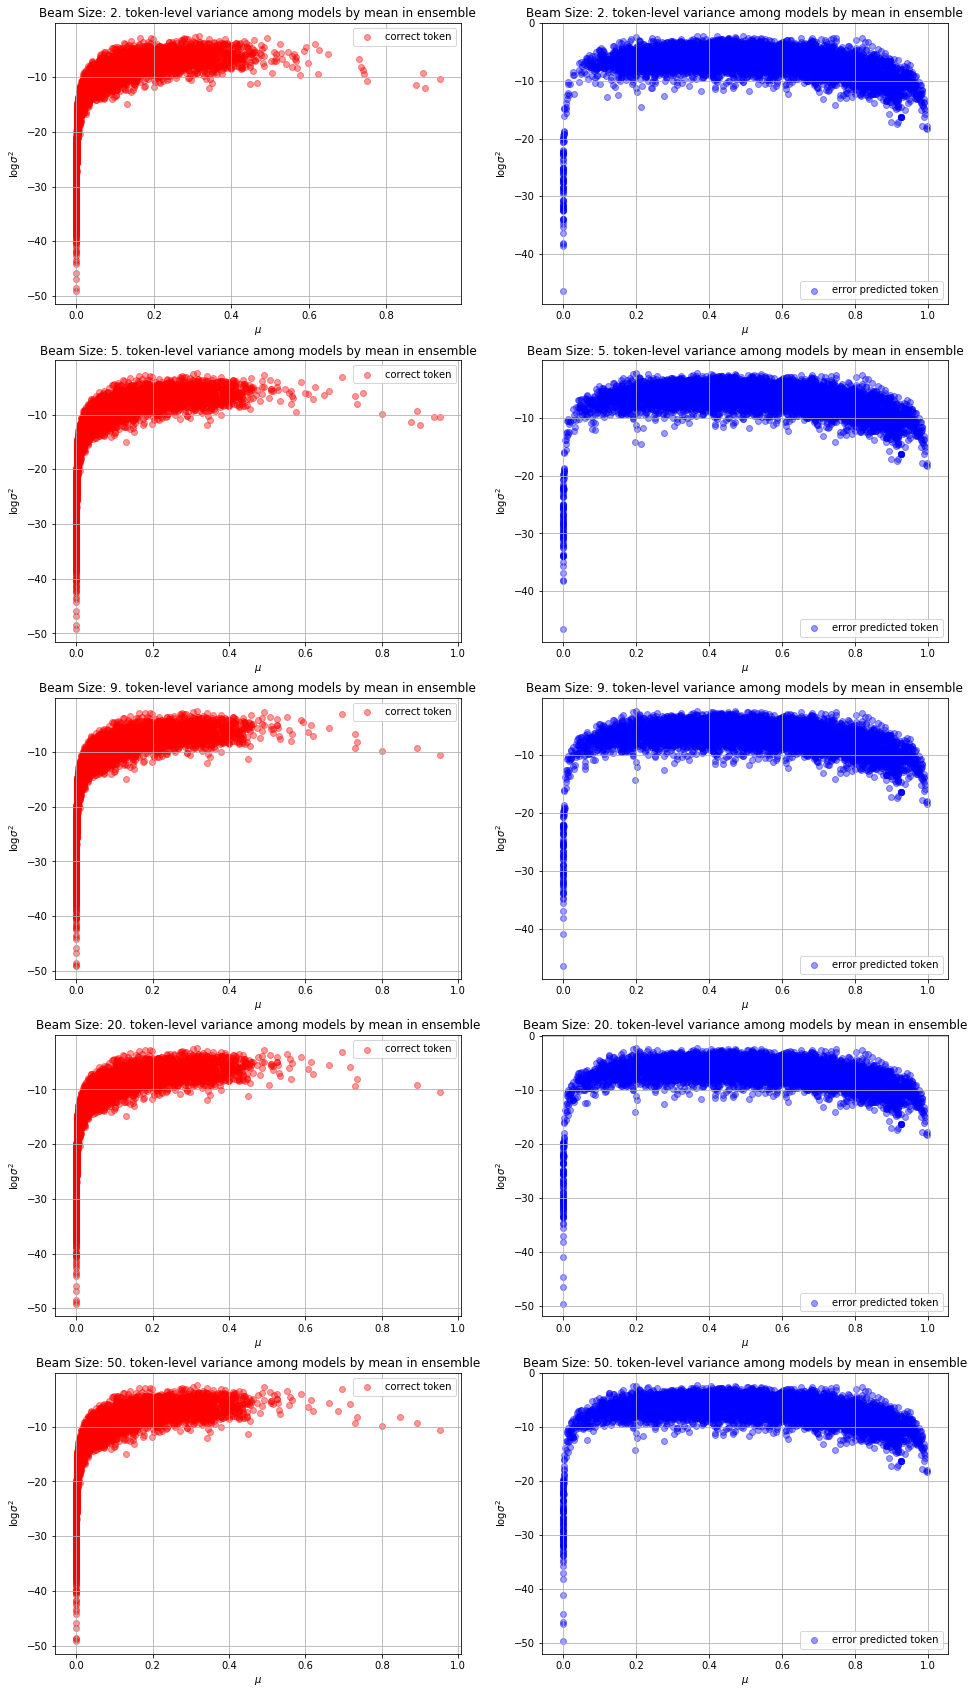

In [87]:
YLIM = (0, 0.2)
XLIM = (-60, 0.5)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'token-level variance among models by mean in ensemble'
YLABEL = r'$\log \sigma^2$'
XLABEL = r'$\mu$'

STATX = 'inens_mean'
STATY = 'inens_var'
EOS_TOKEN = None

plot_stats_scatters(
    beams,
    ('correct token', beam2stats_neg_true),
    ('error predicted token', beam2stats_neg),
    STATX,
    STATY,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    map_func_y=np.log2
)

#### Ensemble softmax variance

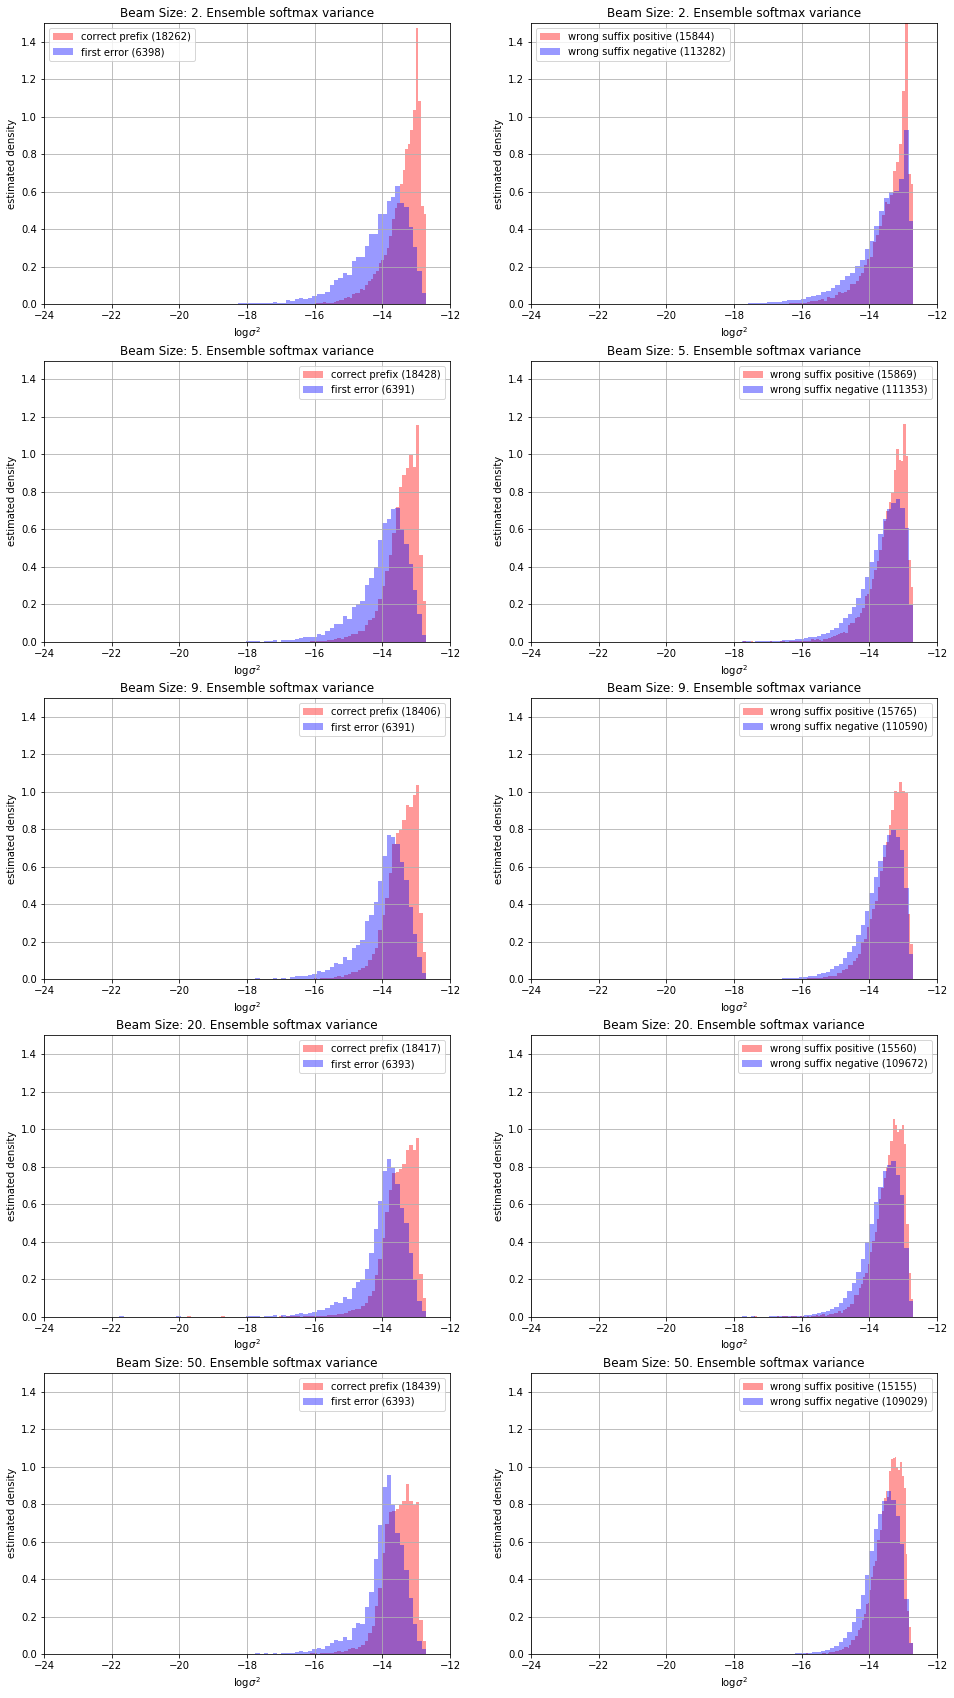

In [79]:
YLIM = (0, 1.5)
XLIM = (-24, -12)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble softmax variance'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT = 'ens_svar'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN,
    np.log2
)

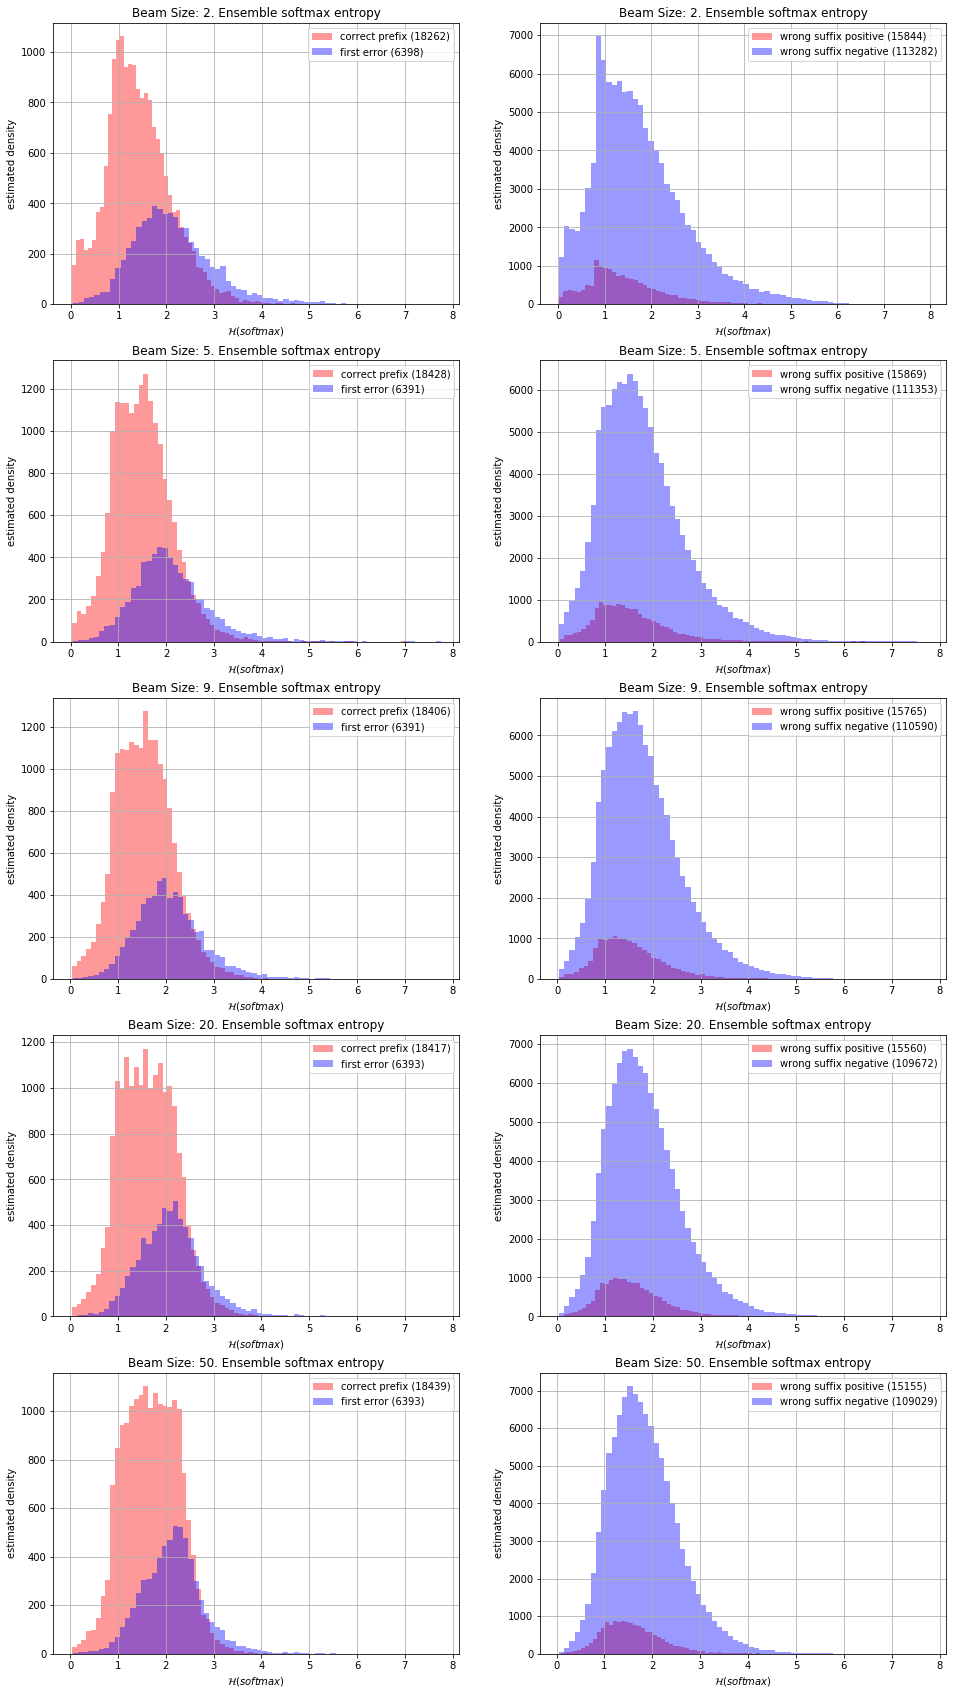

In [80]:
YLIM = (0, 1)
XLIM = None

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble softmax entropy'
XLABEL = r'$\mathcal{H}(softmax)$'
YLABEL = 'estimated density'

STAT = 'ens_entropy'
EOS_TOKEN = None

plot_stats(
    beams,
    ('correct prefix', beam2stats_pos),
    ('first error', beam2stats_neg),
    ('wrong suffix', beam2stats_wrong),
    STAT,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    EOS_TOKEN
)

##### Models' softmax variance

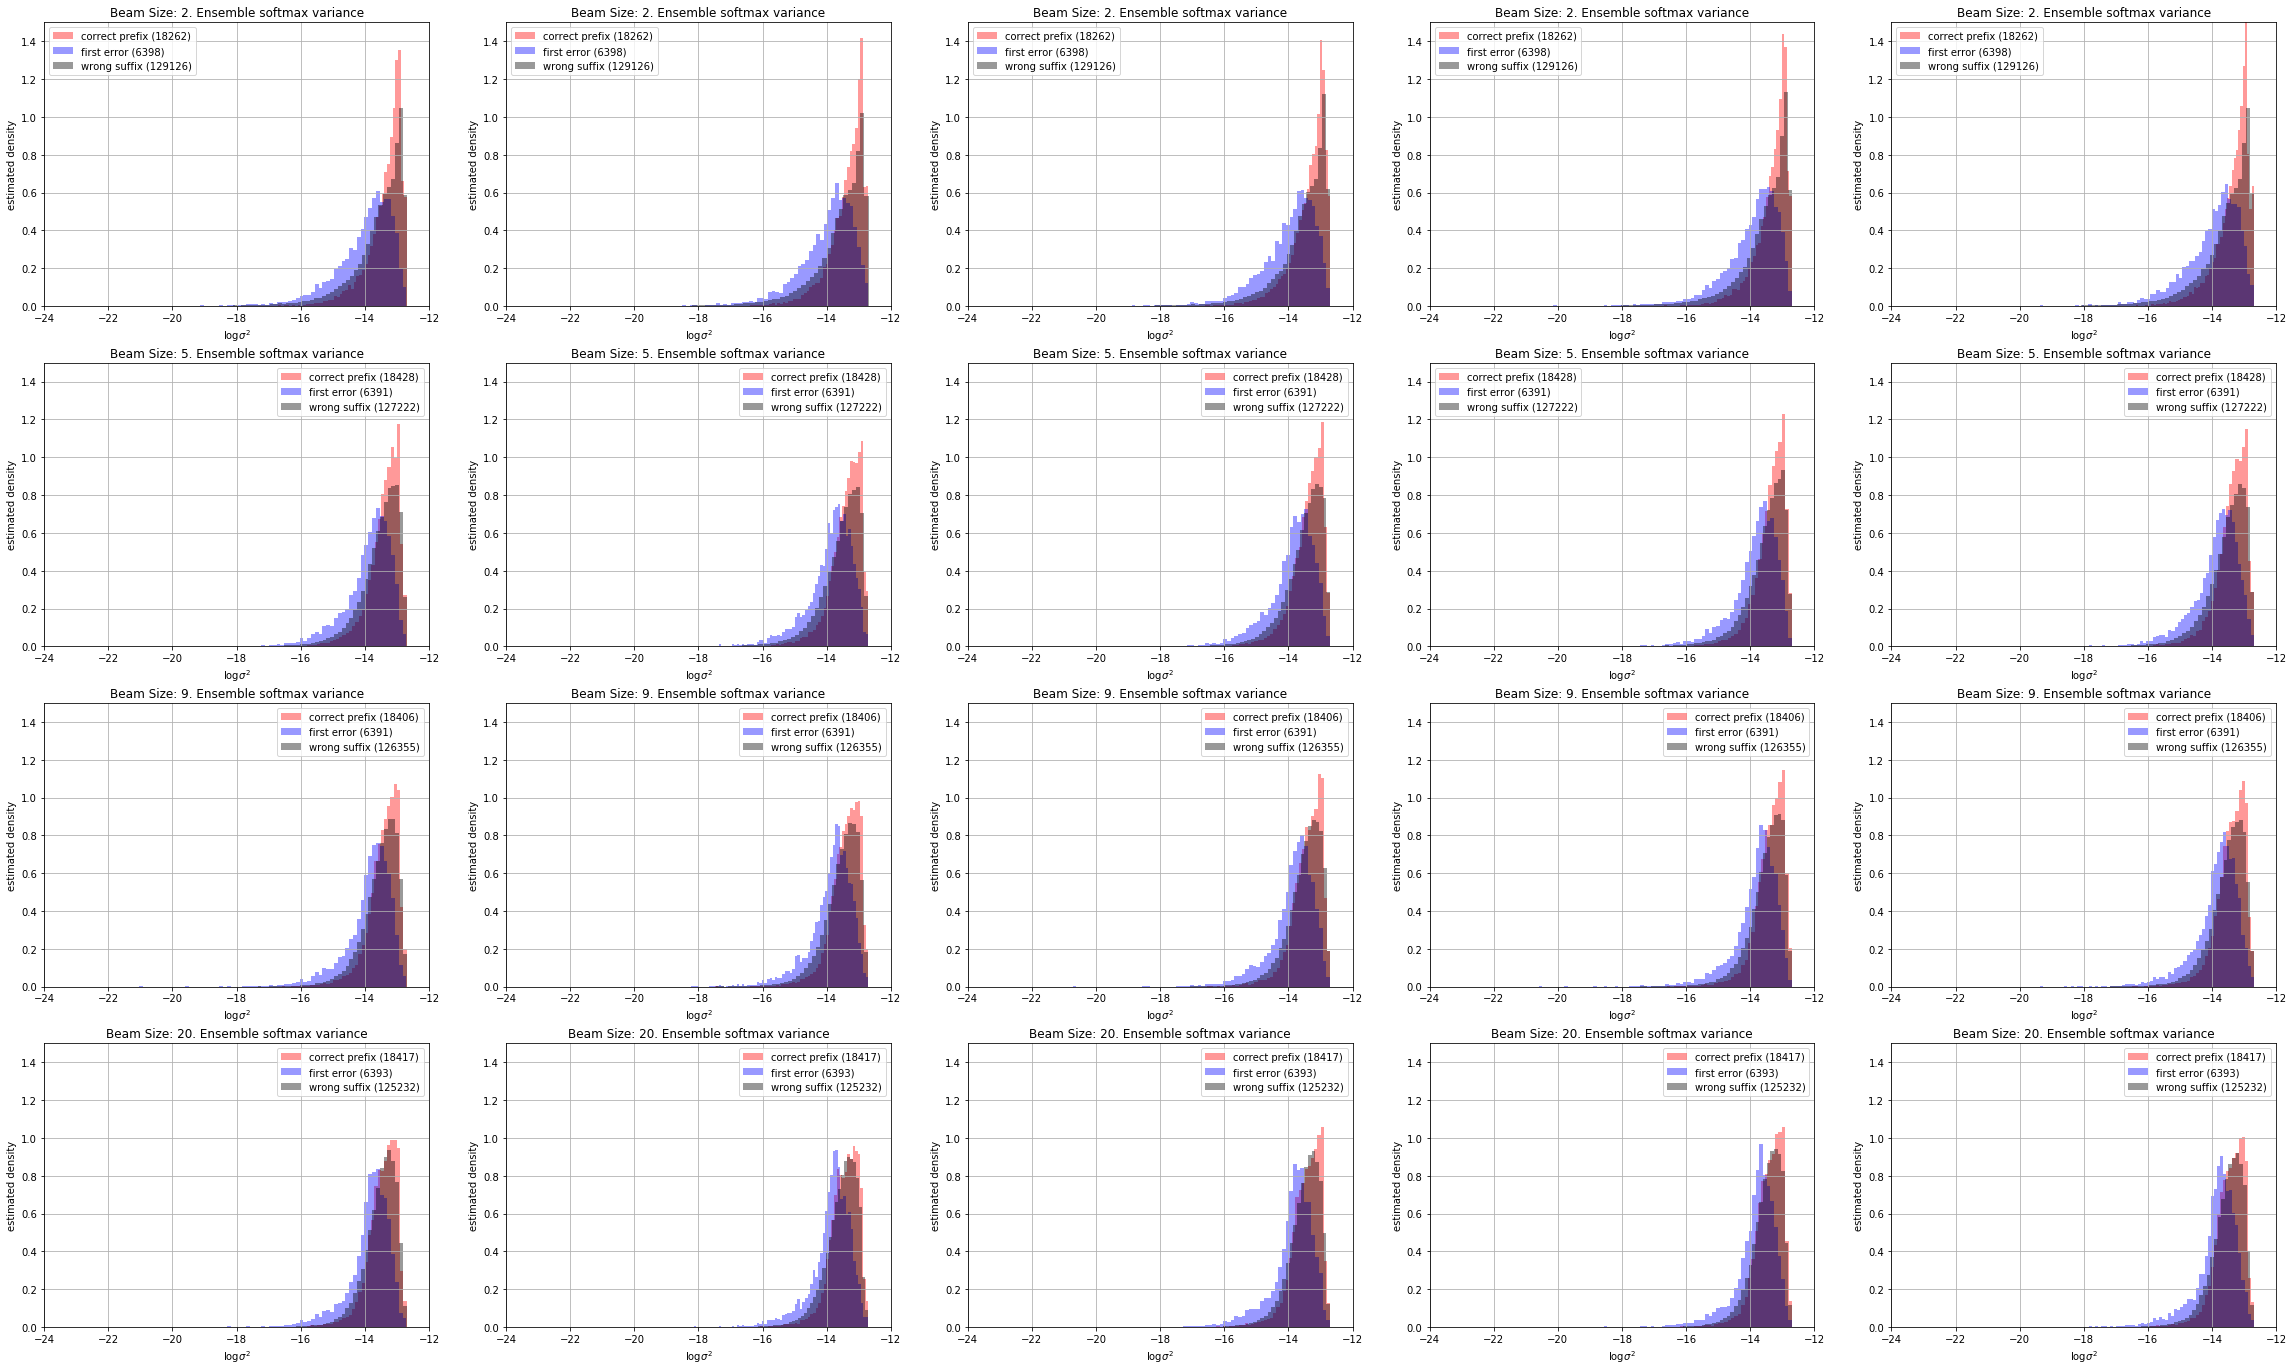

In [59]:
YLIM = (0, 1.5)
XLIM = (-24, -12)

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble softmax variance'
XLABEL = r'$\log \sigma^2$'
YLABEL = 'estimated density'

STAT_PATTERN = 'm{}_svar'

m = MODELS_NUM
n = len(beams)

plt.figure(figsize=(8 * m, 6 * n))
for i, beam in enumerate(sorted(beams)):
    for j in range(MODELS_NUM):
        ax = plt.subplot(n, m, i * m + j + 1)
        STAT = STAT_PATTERN.format(j)
        ax.hist(
            np.log2(np.array(beam2stats_pos[beam][STAT])),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='correct prefix ({})'.format(len(beam2stats_pos[beam][STAT]))
        )
        ax.hist(
            np.log2(np.array(beam2stats_neg[beam][STAT])),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='first error ({})'.format(len(beam2stats_neg[beam][STAT]))
        )    
        ax.hist(
            np.log2(np.array(beam2stats_wrong[beam][STAT])),
            density=density, stacked=stacked,
            color='black', alpha=.4,
            bins=70,
            label='wrong suffix ({})'.format(len(beam2stats_wrong[beam][STAT]))
        )
        ax.set_title('Beam Size: {}. {}'.format(beam, TITLE))
        ax.set_xlabel(XLABEL)
        ax.set_ylabel(YLABEL)
        if YLIM is not None:
            ax.set_ylim(YLIM)
        if XLIM is not None:
            ax.set_xlim(XLIM)
        ax.grid()
        ax.legend()

In [ ]:
YLIM = (0, 1)
XLIM = None

NORMALIZED = True
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = 'Ensemble softmax entropy'
XLABEL = r'$\mathcal{H}(sofmax)$'
YLABEL = 'estimated density'

STAT_PATTERN = 'm{}_entropy'

m = MODELS_NUM
n = len(beams)

plt.figure(figsize=(8 * m, 6 * n))
for i, beam in enumerate(sorted(beams)):
    for j in range(MODELS_NUM):
        ax = plt.subplot(n, m, i * m + j + 1)
        STAT = STAT_PATTERN.format(j)
        ax.hist(
            np.array(beam2stats_pos[beam][STAT]),
            density=density, stacked=stacked,
            color='red', alpha=.4,
            bins=70,
            label='correct prefix ({})'.format(len(beam2stats_pos[beam][STAT]))
        )
        ax.hist(
            np.array(beam2stats_neg[beam][STAT]),
            density=density, stacked=stacked,
            color='blue', alpha=.4,
            bins=70,
            label='first error ({})'.format(len(beam2stats_neg[beam][STAT]))
        )    
        ax.hist(
            np.array(beam2stats_wrong[beam][STAT]),
            density=density, stacked=stacked,
            color='black', alpha=.4,
            bins=70,
            label='wrong suffix ({})'.format(len(beam2stats_wrong[beam][STAT]))
        )
        ax.set_title('Beam Size: {}. {}'.format(beam, TITLE))
        ax.set_xlabel(XLABEL)
        ax.set_ylabel(YLABEL)
        if YLIM is not None:
            ax.set_ylim(YLIM)
        if XLIM is not None:
            ax.set_xlim(XLIM)
        ax.grid()
        ax.legend()

---